# Setup and Audio Visualization

In [1]:
import os
import shutil
import librosa
import scipy
import numpy as np
import tensorflow as tf
import IPython
import IPython.display as ipd 
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
from keras import losses, models, optimizers
from keras.optimizers import Adam
from keras.models import Sequential
from keras.activations import relu, softmax
from keras.utils import Sequence, to_categorical
from keras.layers import (Layer, Input, Flatten, Dropout, BatchNormalization, Reshape, 
                          MaxPool1D, AveragePooling1D, GlobalAveragePooling1D,
                          Conv1D, Dense, LeakyReLU, ReLU, Activation, 
                          LSTM, SimpleRNNCell)
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)

Using TensorFlow backend.


In [3]:
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'
    
print('Using device: ', device)

Using device:  /device:GPU:0


In [4]:
# CONSTS

DURATION = 4
RATIO = 4
SAMPLE_RATE = int(44100/RATIO)
SHAPE = SAMPLE_RATE*DURATION
NOISE_DIM = 500
MFCC = 40
TRAIN_DATA_PATH = "../../Datasets/freesound-audio-tagging/audio_train/"

encode_size = NOISE_DIM
dense_mid_size = 2100

In [158]:
def load_train_data(input_length=SHAPE, label = "Saxophone"):
    train = pd.read_csv("../../Datasets/freesound-audio-tagging/train.csv")
    if label != None:
        train_list = train.loc[train.label == label]
    else: 
        train_list = train
    cur_batch_size = len(train_list)
    train_fname_list = train_list.fname
    X = np.empty((cur_batch_size, input_length))
    for i, train_fname in enumerate(train_fname_list):
        file_path = TRAIN_DATA_PATH + train_fname
        
        # Read and Resample the audio
        data, _ = librosa.core.load(file_path, sr=SAMPLE_RATE, res_type='kaiser_fast')

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        X[i,] = data
    print("Data Loaded...")
    return X
    
def normalization(X):
    mean = X.mean(keepdims=True)
    print("Mean: ", mean)
    std  = X.std(keepdims=True)
    print("Std: ", std)
    X = (X - mean) / std
    print("Data Normalized...")
    return X

def rescale(X, rangeMax=+1, rangeMin=-1):
    maxi = X.max()
    print("Max: ", maxi)
    mini = X.min()
    print("Min: ", mini)
    X = np.interp(X, (mini, maxi), (rangeMin, rangeMax))
    print("Data Rescaled...")
    return X

trainData = load_train_data(input_length=SHAPE, label = "Violin_or_fiddle")
trainData = normalization(trainData)

Data Loaded...
Mean:  [[-1.39052256e-05]]
Std:  [[0.08637429]]
Data Normalized...


In [6]:
train = pd.read_csv("../../Datasets/freesound-audio-tagging/train.csv")
test = pd.read_csv("../../Datasets/freesound-audio-tagging/sample_submission.csv")
print(train.label.unique())

['Hi-hat' 'Saxophone' 'Trumpet' 'Glockenspiel' 'Cello' 'Knock'
 'Gunshot_or_gunfire' 'Clarinet' 'Computer_keyboard' 'Keys_jangling'
 'Snare_drum' 'Writing' 'Laughter' 'Tearing' 'Fart' 'Oboe' 'Flute' 'Cough'
 'Telephone' 'Bark' 'Chime' 'Bass_drum' 'Bus' 'Squeak' 'Scissors'
 'Harmonica' 'Gong' 'Microwave_oven' 'Burping_or_eructation' 'Double_bass'
 'Shatter' 'Fireworks' 'Tambourine' 'Cowbell' 'Electric_piano' 'Meow'
 'Drawer_open_or_close' 'Applause' 'Acoustic_guitar' 'Violin_or_fiddle'
 'Finger_snapping']


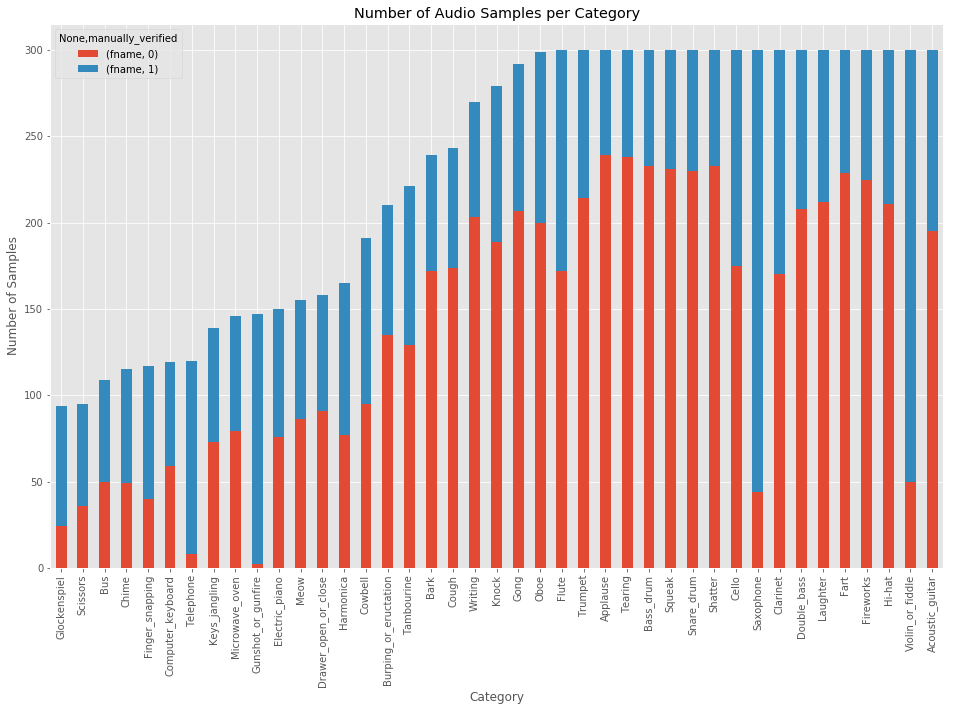

In [132]:
category_group = train.groupby(['label', 'manually_verified']).count()
plot = category_group.unstack().reindex(category_group.unstack().sum(axis=1).sort_values().index)\
          .plot(kind='bar', stacked=True, title="Number of Audio Samples per Category", figsize=(16,10))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");

Total samples (frames) =  (154350,)
[ 4.1569961e-04 -6.4974086e-04  2.8693769e-04 ... -3.6912264e-05
 -5.2365900e-05 -1.1704843e-05]


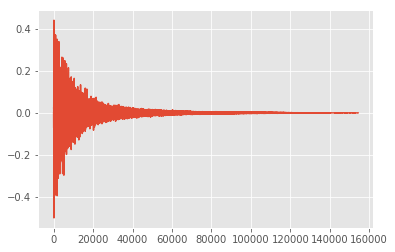

In [7]:
fname = "../../Datasets/freesound-audio-tagging/audio_train/" + "00044347.wav"   # Hi-hat
data, _ = librosa.core.load(fname, sr=SAMPLE_RATE, res_type='kaiser_fast')
print("Total samples (frames) = ", data.shape)
print(data)
IPython.display.display(ipd.Audio(filename=fname))
plt.plot(data, '-', )
plt.show()

Shape:  (40, 44)


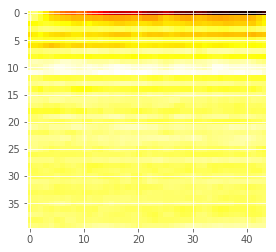

In [8]:
data = data[:2*SAMPLE_RATE]
mfcc = librosa.feature.mfcc(data, sr = SAMPLE_RATE, n_mfcc=40)
print("Shape: ", mfcc.shape)
plt.imshow(mfcc, cmap='hot', interpolation='nearest');

# Using GANs for new sounds

### Discriminator

In [134]:
def discriminator():
    model = Sequential()
    model.add(Reshape((SHAPE, 1), input_shape=(SHAPE,)))
    model.add(Conv1D(32, 11, strides=7, padding='valid'))
    model.add(Activation('linear'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))
    
    model.add(Conv1D(16, 7, strides=5, padding='valid'))
    model.add(Activation('linear'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))
    
    model.add(Conv1D(8, 5, strides=3, padding='valid'))
    model.add(Activation('linear'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))
    model.add(Flatten())
    model.add(Dense(encode_size))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dense(1, activation='tanh'))
    return model

d = discriminator()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_65 (Reshape)         (None, 44100, 1)          0         
_________________________________________________________________
conv1d_230 (Conv1D)          (None, 6299, 32)          384       
_________________________________________________________________
activation_230 (Activation)  (None, 6299, 32)          0         
_________________________________________________________________
batch_normalization_269 (Bat (None, 6299, 32)          128       
_________________________________________________________________
dropout_204 (Dropout)        (None, 6299, 32)          0         
_________________________________________________________________
conv1d_231 (Conv1D)          (None, 1259, 16)          3600      
_________________________________________________________________
activation_231 (Activation)  (None, 1259, 16)          0         
__________

### Generator

In [ ]:
def generator():
    model = Sequential()
    model.add(Dense(dense_mid_size, input_shape=(NOISE_DIM,)))
    #model.add(ReLU())
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Reshape((dense_mid_size,1)))
    
    model.add(Conv1D(32, 7, strides=5, padding='same'))
    #model.add(ReLU())
    model.add(Activation('linear'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))
    
    model.add(Conv1D(64, 5, strides=2, padding='same'))
    #model.add(ReLU())
    model.add(Activation('linear'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))
    
    model.add(Conv1D(128, 3, padding='same'))
    #model.add(ReLU())
    model.add(Activation('linear'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))
    model.add(Conv1D(210, 11, strides=10, padding='same'))
    #model.add(ReLU())
    model.add(Activation('linear'))
    #model.add(AveragePooling1D(100))
    #model.add(BatchNormalization(momentum=0.9))
    #model.add(Dropout(rate=0.1))
    model.add(Flatten())
    return model

g = generator()
g.summary()

### Auto Encoder

In [136]:
# AutoEncoder
def autoEncoder():
    model = Sequential()
    # Encoder
    model.add(Reshape((SHAPE, 1), input_shape=(SHAPE,)))
    model.add(Conv1D(32, 11, strides=7, padding='valid'))
    model.add(Activation('linear'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))
    
    model.add(Conv1D(16, 7, strides=5, padding='valid'))
    model.add(Activation('linear'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))
    
    model.add(Conv1D(8, 5, strides=3, padding='valid'))
    model.add(Activation('linear'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))
    model.add(Flatten())
    #Code
    model.add(Dense(encode_size))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.9))
    #Decoder
    model.add(generator())
    return model

a = autoEncoder()
a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_67 (Reshape)         (None, 44100, 1)          0         
_________________________________________________________________
conv1d_237 (Conv1D)          (None, 6299, 32)          384       
_________________________________________________________________
activation_237 (Activation)  (None, 6299, 32)          0         
_________________________________________________________________
batch_normalization_278 (Bat (None, 6299, 32)          128       
_________________________________________________________________
dropout_211 (Dropout)        (None, 6299, 32)          0         
_________________________________________________________________
conv1d_238 (Conv1D)          (None, 1259, 16)          3600      
_________________________________________________________________
activation_238 (Activation)  (None, 1259, 16)          0         
__________

In [159]:
def run_autoEncoder(X, epochs=20,  save_internal=2, batch=32):
    A = autoEncoder()  
    A.compile(loss = 'mse', optimizer = Adam(lr = 0.0002, beta_1 = 0.5), metrics = ['accuracy'])
    for cnt in range(epochs):
        random_index = np.random.randint(0, len(X) - batch)
        legit_audios = X[random_index : int(random_index + batch)]
        loss = A.train_on_batch( legit_audios, legit_audios)
        if cnt % save_internal == 0 : 
            print("Epoch: ",cnt, ", Loss: ", loss)
    return A

auto = run_autoEncoder(trainData, epochs=100, save_internal=10, batch=64)

Epoch:  0 , Loss:  [1.4346392, 0.0]
Epoch:  10 , Loss:  [1.5068135, 0.0]
Epoch:  20 , Loss:  [1.1714416, 0.0]
Epoch:  30 , Loss:  [1.6924238, 0.0]
Epoch:  40 , Loss:  [1.3774446, 0.0]
Epoch:  50 , Loss:  [1.6554418, 0.0]
Epoch:  60 , Loss:  [1.360571, 0.0]
Epoch:  70 , Loss:  [1.38305, 0.0]
Epoch:  80 , Loss:  [1.5963908, 0.0]
Epoch:  90 , Loss:  [0.98629904, 0.0]


Original:


Max:  0.28595367
Min:  -0.2705569
Data Rescaled...
Result:


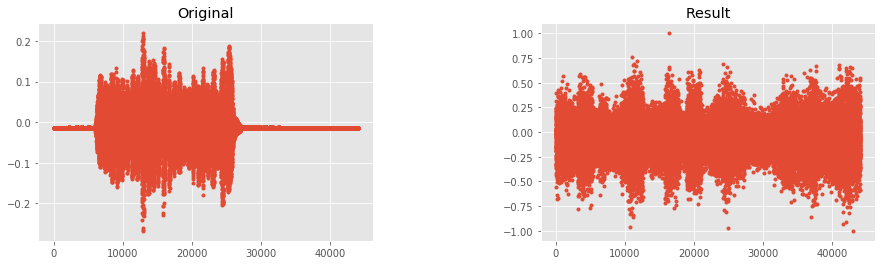

In [157]:
INDEX = 41
print("Original:")
IPython.display.display(ipd.Audio(data=trainData[INDEX], rate=SAMPLE_RATE))
result = rescale(auto.predict(trainData[INDEX].reshape((1,SHAPE))).flatten())
print("Result:")
IPython.display.display(ipd.Audio(data=result, rate=SAMPLE_RATE))
librosa.output.write_wav('./WavFiles/Autoencoder/result1.wav', y=result, sr=SAMPLE_RATE , norm=True)

fig1     = plt.figure(figsize=(1, 2))
Original = fig1.add_subplot(1, 2, 1)
Result   = fig1.add_subplot(1, 2, 2)

Original.set_title('Original')
Result.set_title('Result')
Original.plot(trainData[INDEX], '.', )
Result.plot(result, '.', )

plt.gcf().set_size_inches(15, 4)
plt.subplots_adjust(wspace=0.5,hspace=0.3)
plt.show()

### Stacked Generator and Discriminator

In [173]:
def stacked_G_D(G, D, optimizer):
    model = Sequential()
    model.add(G)
    model.add(D)
    return model

s = stacked_G_D(g,d, Adam(lr = 0.0002, beta_1 = 0.5))
s.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_115 (Sequential)  (None, 44100)             1152520   
_________________________________________________________________
sequential_91 (Sequential)   (None, 1)                 1683857   
Total params: 2,836,377
Trainable params: 2,829,777
Non-trainable params: 6,600
_________________________________________________________________


### Audio GAN

In [187]:
class AudioGAN:
    def __init__(self, label = "Saxophone"):
        self.OPTIMIZER = Adam(lr = 0.0002, beta_1 = 0.5)
        noise_gen = np.random.normal(0,1,(NOISE_DIM,))
        # Generate Models
        self.G = generator()
        self.D = discriminator()
        self.stacked_G_D = stacked_G_D(self.G, self.D, self.OPTIMIZER)
        # Compile Models
        self.G.compile(loss = 'binary_crossentropy', optimizer = self.OPTIMIZER, metrics = ['accuracy'])
        self.D.compile(loss = 'binary_crossentropy', optimizer = self.OPTIMIZER, metrics = ['accuracy'])
        self.stacked_G_D.compile(loss = 'binary_crossentropy', optimizer = self.OPTIMIZER,  metrics = ['accuracy'])
        self.X_train = normalization(load_train_data(SHAPE, label))
        self.D_loss_hist = []
        self.G_loss_hist = []
        
    def train(self, epochs = 20, batch = 32, save_interval = 2):
        for cnt in range(epochs):
            
            # Train discriminator
            halfBatch = int(batch/2)
            random_index = np.random.randint(0, len(self.X_train) - halfBatch)
            legit_audios = self.X_train[random_index : int(random_index + halfBatch)]
            gen_noise = np.random.normal(0, 1, (halfBatch,NOISE_DIM))
            syntetic_audios = self.G.predict(gen_noise)
            x_combined_batch = np.concatenate((legit_audios, syntetic_audios))
            y_combined_batch = np.concatenate((np.ones((halfBatch, 1)), np.zeros((halfBatch, 1))))
               
            # Update stacked discriminator Weights    
            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)
            
            self.stacked_G_D.layers[1].set_weights(self.D.get_weights())  
            stacked_D_Weights = self.stacked_G_D.layers[1].get_weights()
            D_Weights = self.D.get_weights()
                             
            d_loss_mean = np.mean(d_loss)
            self.D_loss_hist.append(d_loss_mean)
            
            # Train stacked generator
            noise = np.random.normal(0, 1, (batch,NOISE_DIM))
            y_mislabled = np.ones((batch, 1))    
            g_loss = self.stacked_G_D.train_on_batch(noise, y_mislabled)
            
            # Update generator Weights
            self.G.set_weights(self.stacked_G_D.layers[0].get_weights())      
            
            g_loss_mean = np.mean(g_loss)
            self.G_loss_hist.append(g_loss_mean)
            if cnt % int(save_interval/2) == 0 : 
                print ("epoch: %d" % (cnt)) 
                print ("Discriminator_loss: %f, Generator_loss: %f" % (d_loss_mean, g_loss_mean))
            if cnt % save_interval == 0 : 
                show_audios(G = self.G)

In [188]:
def show_audios(G, samples = 2):
    fig     = plt.figure(figsize=(1, samples))
    samplePlot = []
    noise = np.random.normal(0, 1, (samples,NOISE_DIM))
    audios = G.predict(noise)
    for i, audio in enumerate(audios):
        print("Audio Gen %d" % i)
        IPython.display.display(ipd.Audio(data=audio, rate=SAMPLE_RATE))
        samplePlot.append(fig.add_subplot(1, samples, i+1))
        samplePlot[i].plot(audio.flatten(), '.', )
    
    plt.gcf().set_size_inches(25, 5)
    plt.subplots_adjust(wspace=0.3,hspace=0.3)
    plt.show()

### Running GAN

In [189]:
myGan = AudioGAN(label = "Violin_or_fiddle")

Data Loaded...
Mean:  [[-3.28848306e-05]]
Std:  [[0.08671426]]
Data Normalized...


epoch: 0
Discriminator_loss: 2.659887, Generator_loss: 4.842555
Audio Gen 0


Audio Gen 1


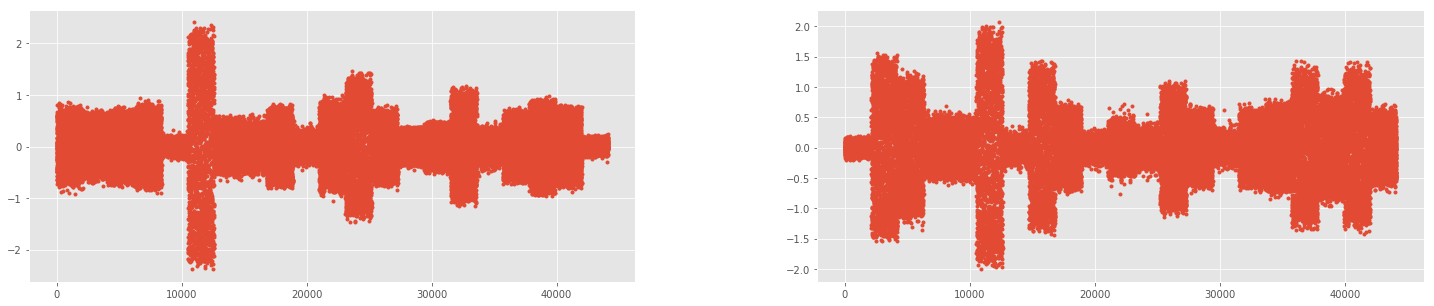

epoch: 5
Discriminator_loss: 1.705635, Generator_loss: 4.593956
epoch: 10
Discriminator_loss: 1.286947, Generator_loss: 4.447190
Audio Gen 0


Audio Gen 1


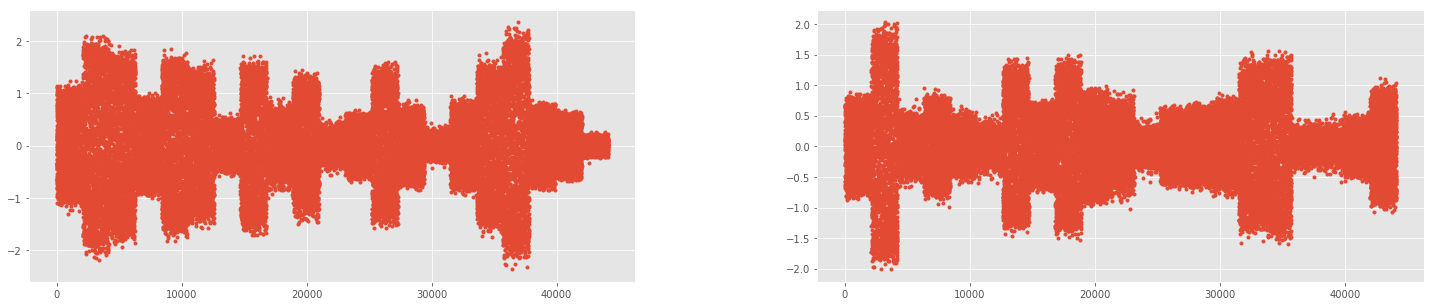

epoch: 15
Discriminator_loss: 0.863029, Generator_loss: 4.358215
epoch: 20
Discriminator_loss: 0.705855, Generator_loss: 4.193149
Audio Gen 0


Audio Gen 1


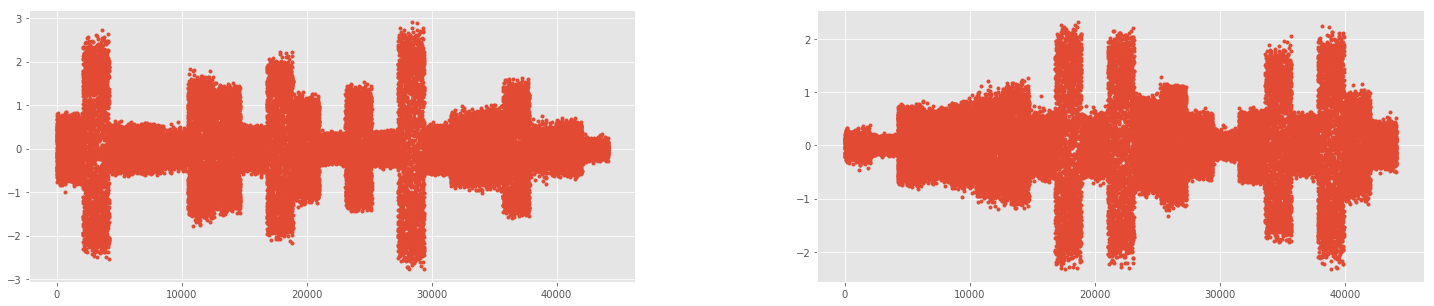

epoch: 25
Discriminator_loss: 0.434989, Generator_loss: 3.535939
epoch: 30
Discriminator_loss: 0.792579, Generator_loss: 3.428030
Audio Gen 0


Audio Gen 1


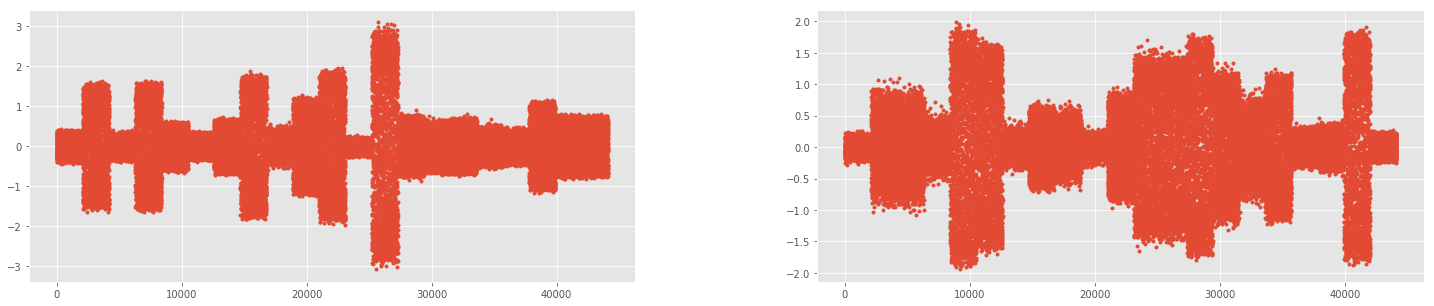

epoch: 35
Discriminator_loss: 0.775896, Generator_loss: 4.532122
epoch: 40
Discriminator_loss: 0.457022, Generator_loss: 3.884857
Audio Gen 0


Audio Gen 1


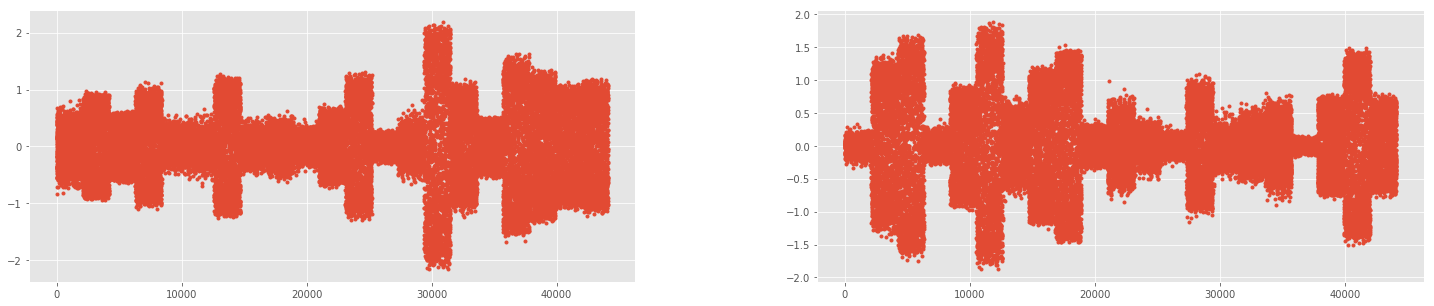

epoch: 45
Discriminator_loss: 0.441624, Generator_loss: 4.318846
epoch: 50
Discriminator_loss: 0.646054, Generator_loss: 3.738726
Audio Gen 0


Audio Gen 1


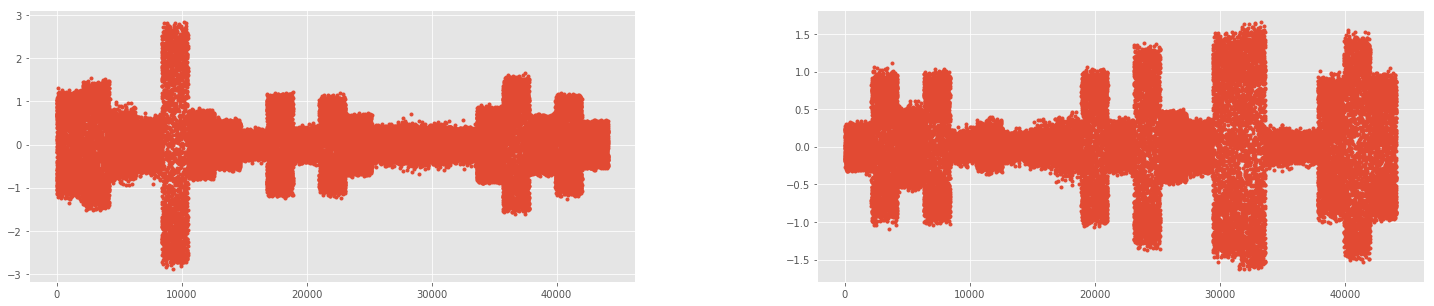

epoch: 55
Discriminator_loss: 0.362917, Generator_loss: 3.745545
epoch: 60
Discriminator_loss: 0.838929, Generator_loss: 4.194722
Audio Gen 0


Audio Gen 1


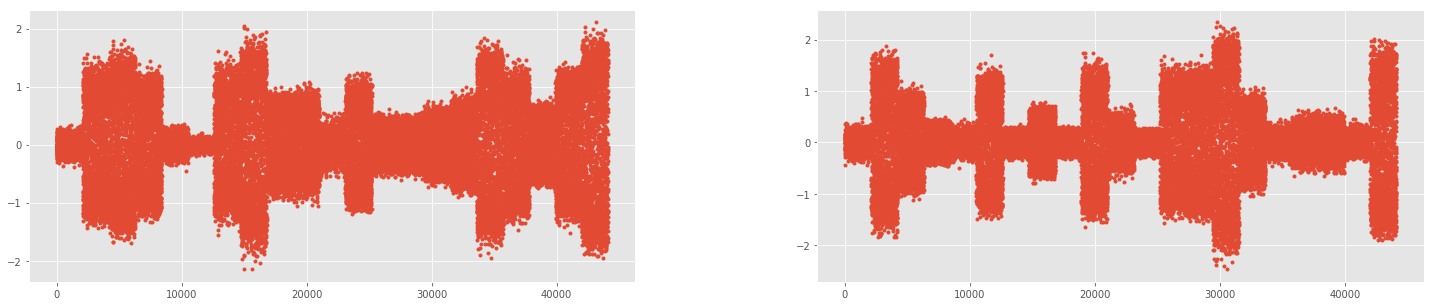

epoch: 65
Discriminator_loss: 0.590325, Generator_loss: 4.073398
epoch: 70
Discriminator_loss: 0.542052, Generator_loss: 3.858573
Audio Gen 0


Audio Gen 1


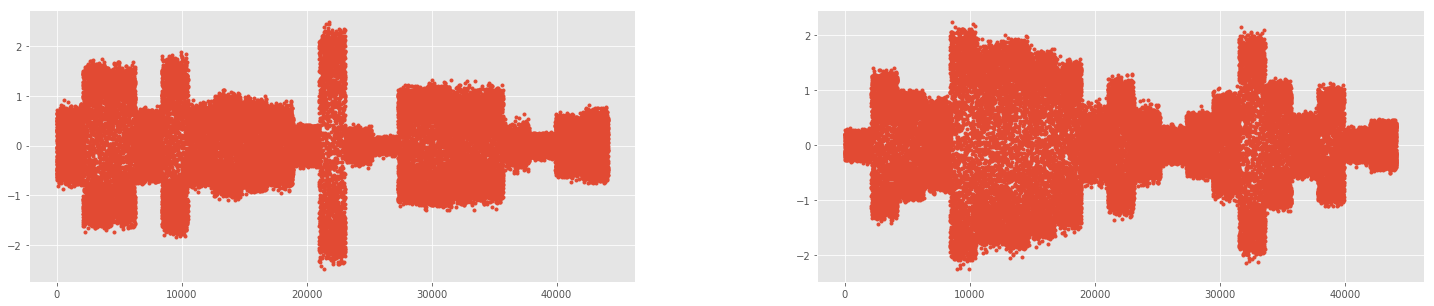

epoch: 75
Discriminator_loss: 0.477234, Generator_loss: 3.390154
epoch: 80
Discriminator_loss: 0.393583, Generator_loss: 4.351141
Audio Gen 0


Audio Gen 1


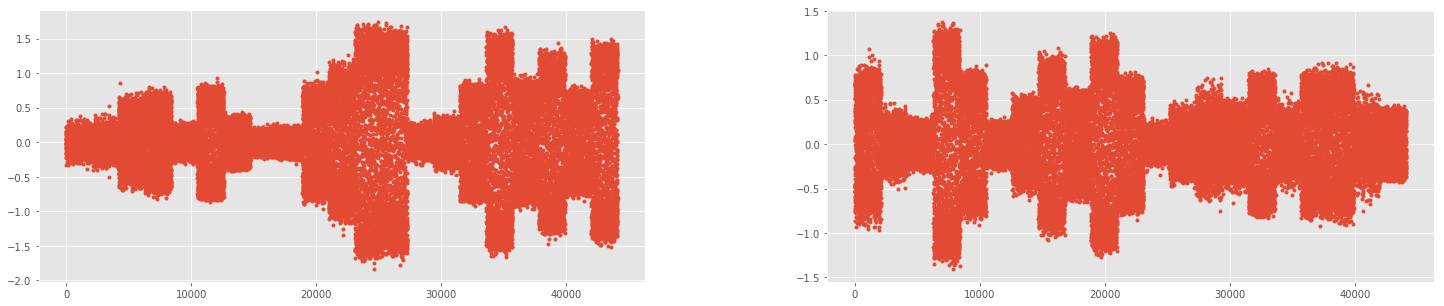

In [ ]:
myGan.train(epochs = 100, batch = 64, save_interval = 10)

### Discriminator and Generator Loss over Epochs

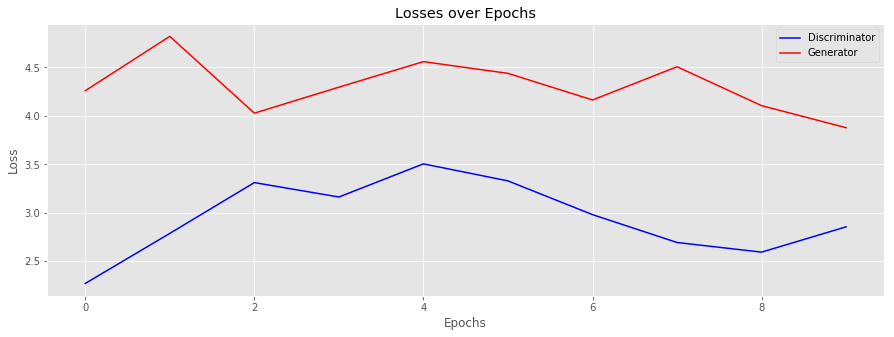

In [184]:
plt.title('Losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(myGan.D_loss_hist, '-', label='Discriminator', color='blue')
plt.plot(myGan.G_loss_hist, '-', label='Generator', color='red')
plt.legend(loc='best')

plt.gcf().set_size_inches(15, 5)
plt.show()

### Test Sample

Generated Audio
[-6.6018105e-04 -5.0655651e-01 -7.5520802e-01 ... -1.0763321e+00
  1.9492459e-01 -7.5810623e-01]


Original Audio
[-0.00743844  0.1176203  -0.38987139 ... -0.22552533 -0.01386573
 -0.32828039]


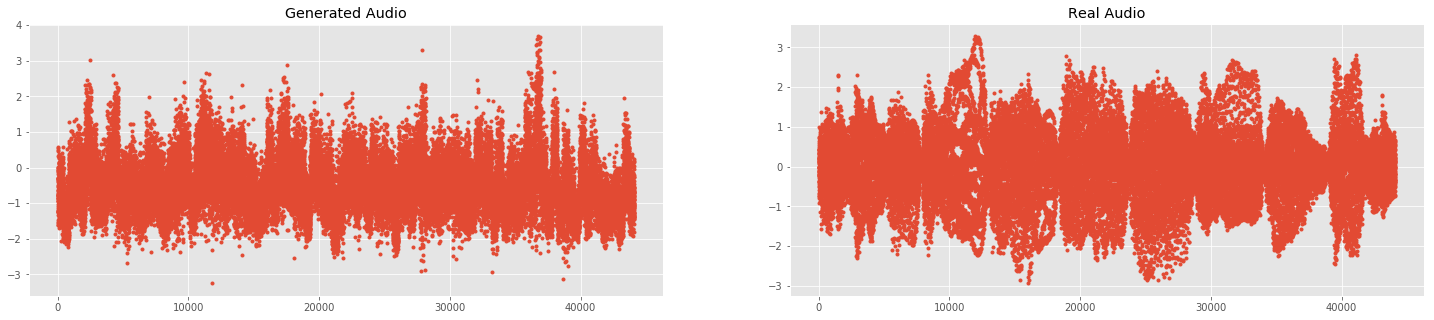

In [181]:
fig2 = plt.figure(figsize=(1, 2))
genT_plt  = fig2.add_subplot(1, 2, 1)
oriT_plt = fig2.add_subplot(1, 2, 2)

genT_plt.set_title('Generated Audio')
oriT_plt.set_title('Real Audio')


gen_noise = np.random.normal(0, 1, (1,NOISE_DIM))
gen_test = myGan.G.predict(gen_noise).flatten()


random_index = np.random.randint(0, len(myGan.X_train))
original = myGan.X_train[random_index]

print("Generated Audio")
print(gen_test)
IPython.display.display(ipd.Audio(data=gen_test, rate=SAMPLE_RATE))
print("Original Audio")
print(original)
IPython.display.display(ipd.Audio(data=original, rate=SAMPLE_RATE))

genT_plt.plot(gen_test, '.', )
oriT_plt.plot(original, '.', )

plt.gcf().set_size_inches(25, 5)
plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()